# Construction Avancée de Portefeuille sur Python

Le projet se divise en 3 sections : 

1) Drawdown et création d'une fonction associée

2) Diversification et création d'un indice pondéré par capitalisation

3) Mise en œuvre de l' algorithme associé à l'assurance de portefeuille (CPPI) et des contraintes de Drawdown



Nous allons d'abord récupérer les données sur lesquelles nous allons travailler :
Il s'agit des rendements mensuels de portefeuilles constitués sur le marché actions américain
pour les grandes et petites capitalisations.
Le prisme d'analyse ici requiert la division de l'ensemble de toutes les actions 
en les classant via des catégories par capitalisation boursière
qu'on pondère finalement de manière égale. 
Il en résulte des portefeuilles, ainsi les donnés analysées reprèsentent les rendement de ces portefeuilles de juillet 1926 à décembre 2018


In [133]:
import pandas as pd
me_m = pd.read_csv("/Users/nassimsahib/Desktop/Data/Portfolios_Formed_on_ME_monthly_EW.csv",
                  header=0, index_col=0, parse_dates=True, na_values=-99.99)

rets = me_m[['Lo 10', 'Hi 10']]
rets.columns = ['SmallCap', 'LargeCap' ]
rets = rets/100

# I) Drawdown et création d'une fonction associée

## Séries Temporelles - forcer l'indice chronologique à être un datetime
Le moyen le plus simple de forcer l'indice chronologique à être une série temporelle consiste à reformater les données d'index en un type "datetime" comme suit :

In [61]:
rets.index = pd.to_datetime(rets.index, format="%Y%m")
rets.index

DatetimeIndex(['1926-07-01', '1926-08-01', '1926-09-01', '1926-10-01',
               '1926-11-01', '1926-12-01', '1927-01-01', '1927-02-01',
               '1927-03-01', '1927-04-01',
               ...
               '2018-03-01', '2018-04-01', '2018-05-01', '2018-06-01',
               '2018-07-01', '2018-08-01', '2018-09-01', '2018-10-01',
               '2018-11-01', '2018-12-01'],
              dtype='datetime64[ns]', length=1110, freq=None)

## Graphique des rendements des portefeuilles Small et Large Cap
Ci-dessous nous avons afficher le graphique repèsentant les rendements des portefeuilles des grandes et petites capitalisation : les 10% des capitalisation boursières les plus grandes ( Hi 10 que l'on a renommé LargeCap) et les 10% des capitalisation boursières les plus petites ( Lo 10 que l'on a renommé Small Cap). On remarque des rendements plus élévés pour les portefeuilles Small Cap, corréspondant au risk-premia d'une plus forte volatilité comparée à celle des portefeuilles Large Cap

<AxesSubplot:>

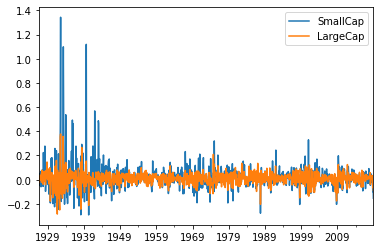

In [30]:
rets.plot.line()

Grace à la formatation du DataFrame a un index datetime réalisée auparavant, nous pouvons traiter le dataframe entier comme une série temporelle, ce qui rend les choses très pratiques. Par exemple, nous pouvons extraire uniquement les rendements en 2008 comme suit :

In [94]:
rets.loc["2008"]

,SmallCap,LargeCap
2008-01,-0.0436,-0.0490
2008-02,-0.0203,-0.0250
2008-03,-0.0440,-0.0122
2008-04,0.0027,0.0492
2008-05,0.0286,0.0161
2008-06,-0.0816,-0.1015
2008-07,-0.0079,-0.0140
2008-08,0.0110,0.0087
2008-09,-0.1274,-0.1155
2008-10,-0.2041,-0.1763


On affiche quelques statistiques descriptives avec 'describe()' telles que : la moyenne, l'écart-type , les centiles et la valeur maximale


In [95]:
rets.describe()

,SmallCap,LargeCap
count,1110.000000,1110.000000
mean,0.017598,0.008870
std,0.106288,0.053900
min,-0.291400,-0.284300
25%,-0.027350,-0.017025
50%,0.010450,0.011400
75%,0.049950,0.037650
max,1.342900,0.377900


## Calcul des Drawdown pour les Large Cap
1. Calcul d'un indice de richesse (que l'on va nommer wealth index)
2. Calcul des pics précédents ( que l'on va nommer previous peaks)
3. Calcul du drawdown : la valeur de la richesse en pourcentage du pic précédent

<AxesSubplot:>

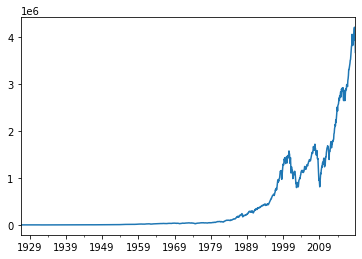

In [99]:
wealth_index = 1000 *(1+rets['LargeCap']).cumprod()
wealth_index.plot()

<AxesSubplot:>

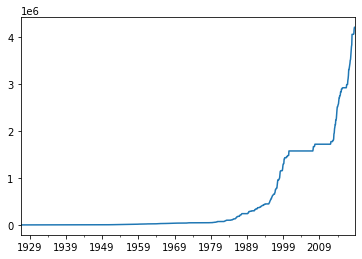

In [100]:
previous_peaks = wealth_index.cummax()
previous_peaks.plot()

<AxesSubplot:>

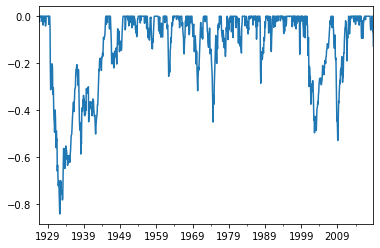

In [101]:
drawdown = (wealth_index - previous_peaks)/previous_peaks
drawdown.plot()

Affichons la valeur minimale constatée lors des drawdown

In [102]:
drawdown.min()

-0.8400375277943123

Affichons tous les drawdown à partir de 1975

<AxesSubplot:>

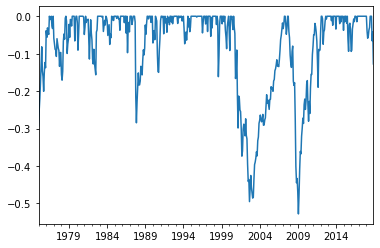

In [103]:
drawdown["1975":].plot()

affichons la valeur exacte du plus grand drawdown sur cette période (de 1975 à 2018)

In [105]:
drawdown["1975":].min()

-0.5280945042309304

## Création d'une fonction de Drawdown

Refaire cette analyse pour les Small Cap serait fastidieux, puisqu'il faudrait ressaisir toutes ces commandes. Au lieu de cela, nous allons créér une fonction qui généralise le processus.

La fonction prendra en entrée une série temporelle de rendements et renverra une série temporelle en tant que DataFrame contenant l'indice de richesse, les pics précédents et les baisses en pourcentage.

In [106]:
def drawdown(return_series: pd.Series):
    """
    Prend une série temporelle de rendements d'actifs.
        renvoie un DataFrame avec des colonnes pour
        l'indice de richesse,
        les pics précédents, et
        le pourcentage de prélèvement
    """
    wealth_index = 1000*(1+return_series).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks
    return pd.DataFrame({"Wealth": wealth_index,
                         "Previous Peak": previous_peaks,
                         "Drawdown" : drawdowns})

drawdown(rets['LargeCap']).head()

,Wealth,Previous Peak,Drawdown
1926-07,1032.900000,1032.900000,0.0000
1926-08,1071.117300,1071.117300,0.0000
1926-09,1078.293786,1078.293786,0.0000
1926-10,1052.091247,1078.293786,-0.0243
1926-11,1080.497711,1080.497711,0.0000


In [107]:
drawdown(rets['LargeCap']).min()

Wealth            405.769102
Previous Peak    1032.900000
Drawdown           -0.840038
dtype: float64

In [121]:
drawdown(rets['SmallCap']).min()

Wealth           491.240323
Previous Peak    985.500000
Drawdown          -0.833001
dtype: float64

On peut également indentifier les dates auquelles surviennent ces drawdown

In [115]:
drawdown(rets['LargeCap'])['Drawdown'].idxmin()

Period('1932-05', 'M')

In [116]:
drawdown(rets['SmallCap'])['Drawdown'].idxmin()

Period('1932-05', 'M')

In [118]:
drawdown(rets['LargeCap']["1975":])['Drawdown'].idxmin()

Period('2009-02', 'M')

In [122]:
drawdown(rets['SmallCap']["1975":])['Drawdown'].idxmin()

Period('2009-02', 'M')

Egalement localiser la valeur exacte du drawdown survenu à cette période

In [132]:
drawdown(rets['SmallCap']["1975":])['Drawdown'].min()

-0.6312068077252386

# 2) Diversification et création d'un indice pondéré par capitalisation

La diversification peut s'avérer inefficace en cas de crash boursier :
L'une des raisons est que les corrélations entre les actifs augmentent à mesure que le marché baisse. Voyons si nous pouvons voir cela dans le nouveau jeu de données que nous allons utiliser.

In [134]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np 
import pandas as pd


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


nous allons également importe un fichier texte dans lequel nous avons enregistré la 'fonction drawdown' construite auparavant ainsi que des autres outils utiles à notre analyse

In [148]:
import asset_management_kit as amk

Nous allons charger les rendements par industrie pondérés par leur capitalisation boursière du marché action américain de 1926 à 2018 : on peut constater les diffèrents secteurs (Bière, Jeux, Livres...)

In [143]:
ind_return = amk.get_ind_returns()
ind_return.head()

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
1926-07,0.0056,-0.0519,0.0129,0.0293,0.1097,-0.0048,0.0808,0.0177,0.0814,0.0039,...,0.0083,0.0922,0.0206,0.0770,0.0193,-0.2379,0.0007,0.0187,0.0037,0.0520
1926-08,0.0259,0.2703,0.0650,0.0055,0.1001,-0.0358,-0.0251,0.0425,0.0550,0.0814,...,0.0217,0.0202,0.0439,-0.0238,0.0488,0.0539,-0.0075,-0.0013,0.0446,0.0676
1926-09,0.0116,0.0402,0.0126,0.0658,-0.0099,0.0073,-0.0051,0.0069,0.0533,0.0231,...,0.0241,0.0225,0.0019,-0.0554,0.0005,-0.0787,0.0025,-0.0056,-0.0123,-0.0386
1926-10,-0.0306,-0.0331,0.0106,-0.0476,0.0947,-0.0468,0.0012,-0.0057,-0.0476,0.0100,...,-0.0011,-0.0200,-0.0109,-0.0508,-0.0264,-0.1538,-0.0220,-0.0411,-0.0516,-0.0849
1926-11,0.0635,0.0729,0.0455,0.0166,-0.0580,-0.0054,0.0187,0.0542,0.0520,0.0311,...,0.0163,0.0377,0.0364,0.0384,0.0160,0.0467,0.0652,0.0433,0.0224,0.0400


## Construisons un portefeuille pondéré en fonction de la capitalisation boursière : 
La plupart des indices boursiers sont construits en prenant un ensemble d'actifs et en les pondérant par leur valeur boursière, c'est-à-dire la capitalisation boursière.

Construisons un indice pondéré par la capitalisation boursière à partir de nos 30 portefeuilles sectoriels.

Pour chacune de ces industries, nous avons également des données sur le nombre d'actions dans chaque industrie ainsi que la capitalisation boursière moyenne dans chaque industrie. Ainsi, nous pouvons multiplier la capitalisation boursière moyenne par le nombre d'entreprises pour obtenir la capitalisation boursière totale de chaque industrie. Nous pouvons ensuite pondérer chaque portefeuille sectoriel proportionnellement à la capitalisation boursière de ce secteur.

Chargeons la taille de l'industrie et le nombre moyen d'entreprises :

In [147]:
ind_nfirms = amk.get_ind_nfirms()
ind_size = amk.get_ind_size()


In [149]:
ind_nfirms.head()

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
1926-07,43.0,3.0,16.0,7.0,2.0,8.0,12.0,7.0,17.0,13.0,...,5.0,3.0,7.0,6.0,74.0,2.0,33.0,6.0,12.0,4.0
1926-08,43.0,3.0,16.0,7.0,2.0,8.0,12.0,7.0,17.0,13.0,...,5.0,3.0,7.0,6.0,74.0,2.0,33.0,6.0,12.0,4.0
1926-09,43.0,3.0,16.0,7.0,2.0,8.0,12.0,7.0,17.0,13.0,...,5.0,3.0,7.0,6.0,74.0,2.0,33.0,6.0,12.0,4.0
1926-10,43.0,3.0,16.0,7.0,2.0,8.0,12.0,7.0,17.0,13.0,...,5.0,3.0,7.0,6.0,74.0,2.0,33.0,6.0,12.0,4.0
1926-11,43.0,3.0,16.0,7.0,2.0,8.0,12.0,7.0,17.0,13.0,...,5.0,3.0,7.0,6.0,74.0,2.0,33.0,6.0,12.0,4.0


In [151]:
ind_size.head()

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
1926-07,35.98,7.12,59.72,26.41,12.02,22.27,18.36,25.52,57.59,6.18,...,350.36,13.60,56.70,35.35,66.91,1.19,46.65,10.82,18.83,24.25
1926-08,36.10,6.75,60.47,27.17,13.33,22.13,19.83,25.80,62.13,6.20,...,353.27,14.75,57.74,37.86,67.99,0.90,46.57,11.00,18.88,25.51
1926-09,37.00,8.58,64.03,27.30,14.67,21.18,19.29,26.73,65.53,6.71,...,360.96,15.05,59.61,36.82,71.02,0.95,46.11,10.94,19.67,27.21
1926-10,37.14,8.92,64.42,28.76,14.42,21.23,19.03,26.87,68.47,6.82,...,364.16,15.30,59.52,34.77,70.83,0.88,46.15,10.80,19.36,26.16
1926-11,35.88,8.62,65.08,27.38,15.79,20.14,19.03,26.54,65.06,6.84,...,363.74,14.89,58.74,32.80,68.75,0.74,45.03,10.33,18.35,23.94


Maintenant que nous avons les capitalisations boursières pour chaque mois, nous pouvons calculer la capitalisation boursière totale au fil du temps en additionnant toutes les industries :

In [158]:
ind_mktcap = ind_nfirms * ind_size
total_mktcap = ind_mktcap.sum(axis=1)


Afficheons graphiquement la capitalisations bourisère totale

<AxesSubplot:>

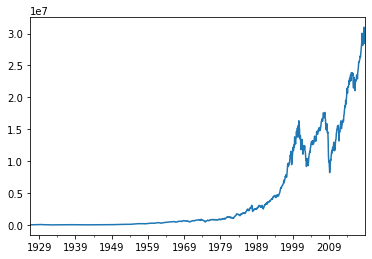

In [156]:
total_mktcap.plot()

Nous pouvons maintenant calculer le capweight de chaque industrie comme suit :

In [163]:
ind_capweight = ind_mktcap.divide(total_mktcap, axis="rows")

Examinons la fraction du marché occupée par l'industrie sidérurgique (nommée 'Steel') au fil du temps et comparons-la à l'industrie financière (nommée 'Fin').

<AxesSubplot:>

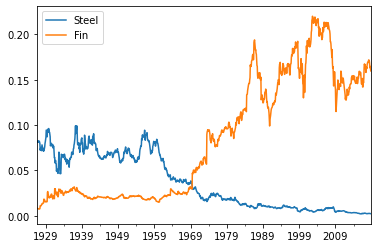

In [164]:
ind_capweight[["Steel", "Fin"]].plot()

## Construisons un indice de marché pondéré en fonction de la capitalisation

Une façon de construire un indice de marché consiste à construire un portefeuille dont les pondérations sont rééquilibrées vers les pondérations cibles à chaque période. En réalité, les poids peuvent dériver dans le temps mais cette simplification est assez proche.

<AxesSubplot:title={'center':' Indice capitalisation boursière totale 1926-2018'}>

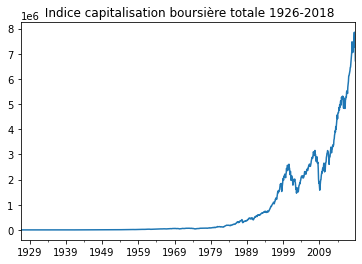

In [172]:
total_market_return = (ind_capweight * ind_return).sum(axis="columns")
total_market_index = amk.drawdown(total_market_return).Wealth
total_market_index.plot(title=" Indice capitalisation boursière totale 1926-2018")

Nous allons enregistrer ce processus dans notre asset_management_kit en y sauvegardant ceci : 
```python
def get_total_market_index_returns():
    """
    Load the 30 industry portfolio data and derive the returns of a capweighted total market index
    """
    ind_nfirms = get_ind_nfirms()
    ind_size = get_ind_size()
    ind_return = get_ind_returns()
    ind_mktcap = ind_nfirms * ind_size
    total_mktcap = ind_mktcap.sum(axis=1)
    ind_capweight = ind_mktcap.divide(total_mktcap, axis="rows")
    total_market_return = (ind_capweight * ind_return).sum(axis="columns")
    return total_market_return
```

<AxesSubplot:title={'center':'Indice capitalisation boursière totale 1926-2018'}>

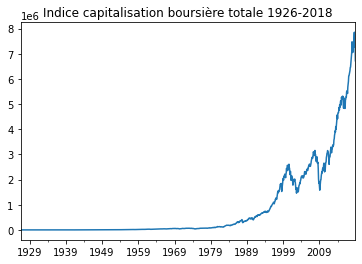

In [174]:
total_market_return = amk.get_total_market_index_returns()
total_market_index = amk.drawdown(total_market_return).Wealth
total_market_index.plot(title="Indice capitalisation boursière totale 1926-2018")

## Fenêtres glissantes

Construisons une fenêtre glissante de rendements sur une période de 36 mois. Pandas contient un support direct pour les fenêtres roulantes et nous permet d'agréger les retours sur une fenêtre. Dans notre cas, calculons le rendement moyen sur une fenêtre de 36 mois.

<AxesSubplot:>

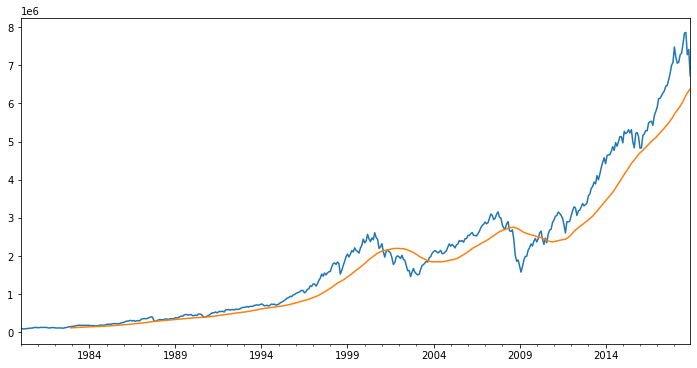

In [177]:
total_market_index["1980":].plot(figsize=(12, 6))
total_market_index["1980":].rolling(window=36).mean().plot()

Nous ne voulons pas vraiment le rendement moyen, nous voulons regarder le rendement composé sur 3 ans. Nous devons appliquer notre propre fonction, au lieu de `mean()`.

Chaque fois que la fenêtre est avancée, un nouveau DataFrame (avec juste la tranche du DataFrame dans la fenêtre) est utilisé pour générer une nouvelle valeur. Nous pouvons soit utiliser l'une des méthodes DataFrame intégrées comme `.mean` mais également la méthode `.aggregate` pour appliquer notre propre fonction à chaque colonne pour toutes les lignes qui tombent dans cette fenêtre.

Créons une série chronologique des rendements annualisés sur les 36 derniers mois et la corrélation moyenne entre les actions sur ces mêmes 36 mois.

<AxesSubplot:>

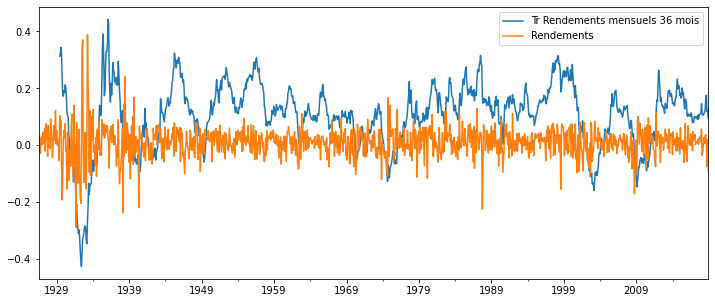

In [189]:
tmi_tr36rets = total_market_return.rolling(window=36).aggregate(amk.annualize_rets, periods_per_year=12)
tmi_tr36rets.plot(figsize=(12,5), label="Tr Rendements mensuels 36 mois", legend=True)
total_market_return.plot(label="Rendements", legend=True)

## Corrélations glissantes : index multiples et `.groupby`

Ensuite, nous voulons examiner les corrélations moyennes entre toutes les industries sur cette même fenêtre de 3 ans.

Commençons par construire la série chronologique des corrélations dans le temps sur une fenêtre de 36 mois.

In [183]:
ts_corr = ind_return.rolling(window=36).corr()
ts_corr.tail()

Food      Beer     Smoke     Games     Books     Hshld  \
2018-12 Whlsl  0.474948  0.356983  0.122672  0.510425  0.803362  0.419280   
        Rtail  0.517856  0.406107  0.030283  0.676464  0.636320  0.358336   
        Meals  0.370187  0.385483  0.122007  0.301516  0.520649  0.308216   
        Fin    0.298823  0.192706  0.027593  0.480276  0.694812  0.162690   
        Other  0.436952  0.376565  0.224010  0.331829  0.558072  0.390610   

                  Clths      Hlth     Chems     Txtls  ...     Telcm  \
2018-12 Whlsl  0.570071  0.739764  0.785796  0.634197  ...  0.648092   
        Rtail  0.676598  0.714933  0.626034  0.634202  ...  0.562238   
        Meals  0.302176  0.416193  0.520023  0.491726  ...  0.406184   
        Fin    0.425899  0.658468  0.760151  0.577090  ...  0.420863   
        Other  0.467099  0.645035  0.712511  0.520953  ...  0.607868   

                  Servs     BusEq     Paper     Trans     Whlsl     Rtail  \
2018-12 Whlsl  0.567395  0.543362  0.764252  0.829185  1.000000  0.744842   
        Rtail  0.762616  0.628246  0.656510  0.630615  0.744842  1.000000   
        Meals  0.444629  0.399438  0.627113  0.663358  0.643879  0.616947   
        Fin    0.585418  0.517947  0.670936  0.760730  0.746480  0.611883   
        Other  0.460322  0.434487  0.773798  0.756961  0.767652  0.619918   

                  Meals       Fin     Other  
2018-12 Whlsl  0.643879  0.746480  0.767652  
        Rtail  0.616947  0.611883  0.619918  
        Meals  1.000000  0.502563  0.605226  
        Fin    0.502563  1.000000  0.734837  
        Other  0.605226  0.734837  1.000000  

[5 rows x 30 columns]

Ce qui est créé est un DataFrame avec un index multiniveau. Le premier niveau est la date et le second niveau est le nom de l'industrie. Nous pouvons rendre cela plus facile à voir si nous donnons des noms aux niveaux de l'index :

In [184]:
ts_corr.index.names = ['date', 'industry']
ts_corr.tail()

Food      Beer     Smoke     Games     Books     Hshld  \
date    industry                                                               
2018-12 Whlsl     0.474948  0.356983  0.122672  0.510425  0.803362  0.419280   
        Rtail     0.517856  0.406107  0.030283  0.676464  0.636320  0.358336   
        Meals     0.370187  0.385483  0.122007  0.301516  0.520649  0.308216   
        Fin       0.298823  0.192706  0.027593  0.480276  0.694812  0.162690   
        Other     0.436952  0.376565  0.224010  0.331829  0.558072  0.390610   

                     Clths      Hlth     Chems     Txtls  ...     Telcm  \
date    industry                                          ...             
2018-12 Whlsl     0.570071  0.739764  0.785796  0.634197  ...  0.648092   
        Rtail     0.676598  0.714933  0.626034  0.634202  ...  0.562238   
        Meals     0.302176  0.416193  0.520023  0.491726  ...  0.406184   
        Fin       0.425899  0.658468  0.760151  0.577090  ...  0.420863   
        Other     0.467099  0.645035  0.712511  0.520953  ...  0.607868   

                     Servs     BusEq     Paper     Trans     Whlsl     Rtail  \
date    industry                                                               
2018-12 Whlsl     0.567395  0.543362  0.764252  0.829185  1.000000  0.744842   
        Rtail     0.762616  0.628246  0.656510  0.630615  0.744842  1.000000   
        Meals     0.444629  0.399438  0.627113  0.663358  0.643879  0.616947   
        Fin       0.585418  0.517947  0.670936  0.760730  0.746480  0.611883   
        Other     0.460322  0.434487  0.773798  0.756961  0.767652  0.619918   

                     Meals       Fin     Other  
date    industry                                
2018-12 Whlsl     0.643879  0.746480  0.767652  
        Rtail     0.616947  0.611883  0.619918  
        Meals     1.000000  0.502563  0.605226  
        Fin       0.502563  1.000000  0.734837  
        Other     0.605226  0.734837  1.000000  

[5 rows x 30 columns]

Pour calculer les corrélations glissantes, nous devons regrouper toutes les lignes pour la même date, puis calculer la moyenne de toutes les entrées de la base de données.

Nous devons calculer la moyenne de toutes les valeurs de la base de données, pas la moyenne de chaque colonne. Nous pourrions calculer les moyennes des moyennes, mais il est plus simple d'appeler simplement notre propre fonction sur la matrice de corrélation.

Bien que nous puissions construire une fonction pour calculer cela, il est souvent plus facile de fournir une fonction `lambda` qui est une simple fonction à usage unique et n'a donc pas de nom. Dans tous les autres cas, c'est une fonction pandas standard.

Nous procédons comme suit :

In [186]:
ind_tr36corr = ts_corr.groupby(level='date').apply(lambda cormat: cormat.values.mean())

Maintenant, nous pouvons tracer les rendements des 36 derniers mois par rapport aux corrélations moyennes des 36 derniers mois.

<AxesSubplot:xlabel='date'>

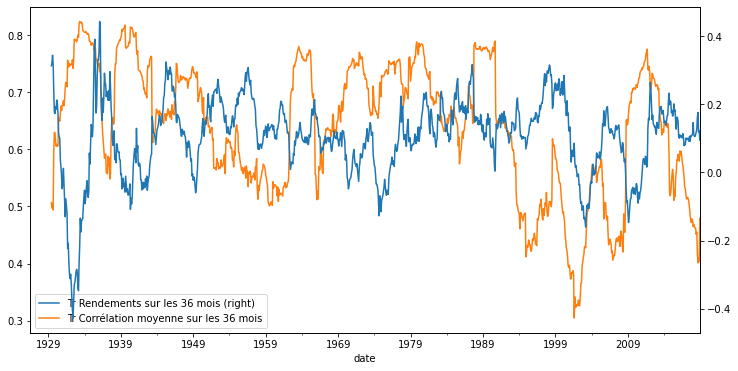

In [190]:
tmi_tr36rets.plot(secondary_y=True, legend=True, label="Tr Rendements sur les 36 mois", figsize=(12,6))
ind_tr36corr.plot(legend=True, label="Tr Corrélation moyenne sur les 36 mois")

In [191]:
tmi_tr36rets.corr(ind_tr36corr)

-0.28010065062884

De toute évidence, ces deux séries sont négativement corrélées, ce qui explique pourquoi la diversification échoue lorsque nous en avons le plus besoin. Lorsque les marchés chutent, les corrélations augmentent, ce qui rend la diversification beaucoup moins précieuse.

Au lieu de cela, nous verrons comment utiliser l'assurance pour protéger les risques.

 # Mise en œuvre de l'assurance de portefeuille (CPPI) et des contraintes de Drawdown
 
 L'assurance de portefeuille `a proportion constante (Constant Proportion Portfolio Insurance ou CPPI), née au milieu des années 80, est une technique de gestion dynamique qui permet d'assurer une garantie minimale `a échéance `a l'investisseur et `a profiter de l'effet de levier du marché.
 
Nous commencerons par mettre en œuvre l'algorithme de base de budgétisation dynamique des risques de l'assurance de portefeuille à proportion constante et le testerons sur différents portefeuilles.

Nous allons utiliser les données précedemment utilisées : les rendements de l'industrie et l'indice total du marché

In [194]:
# l'actif risqué défini risky_r à partir de notre jeu de données sur ces industries : metal, finance et bière
risky_r = ind_return["2000":][["Steel", "Fin", "Beer"]]

# Supposons que l'actif sans risque retourne 3 % par an
safe_r = pd.DataFrame().reindex_like(risky_r)

safe_r.values[:] = 0.03/12 # moyen rapide de définir toutes les valeurs sur un nombre

start = 1000 # à partir de 1 000 $

floor = 0.80 # on fixe le plancher à 80 % de la valeur de départ

Maintenant, nous devons tester cette stratégie en commençant par le début et à chaque instant :

1. Calcul du coussin (valeur de l'actif moins plancher)
2. Calcul de l'allocation (basée sur le multiplicateur)
3. Calcul de la nouvelle valeur de l'actif

In [196]:
# configuration des paramètres CPPI
n_steps = len(dates)
account_value = start
floor_value = start*floor
m = 3

## configuration des DataFrames pour enregistrer les valeurs intermédiaires
account_history = pd.DataFrame().reindex_like(risky_r)
risky_w_history = pd.DataFrame().reindex_like(risky_r)
cushion_history = pd.DataFrame().reindex_like(risky_r)


In [198]:
for step in range(n_steps):
    cushion = (account_value - floor_value)/account_value
    risky_w = m*cushion
    risky_w = np.minimum(risky_w, 1)
    risky_w = np.maximum(risky_w, 0)
    safe_w = 1-risky_w
    risky_alloc = account_value*risky_w
    safe_alloc = account_value*safe_w
    # recalcul de la nouvelle valeur du compte à la fin de cette étape
    account_value = risky_alloc*(1+risky_r.iloc[step]) + safe_alloc*(1+safe_r.iloc[step])
    # enregistrement des historiques pour analyse et graphique
    cushion_history.iloc[step] = cushion
    risky_w_history.iloc[step] = risky_w
    account_history.iloc[step] = account_value
    risky_wealth = start*(1+risky_r).cumprod()

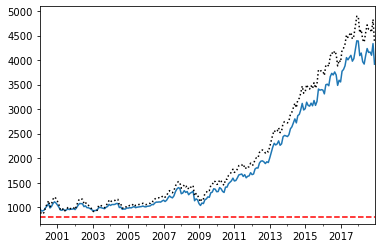

In [202]:
ind = "Beer"
ax = account_history[ind].plot()
risky_wealth[ind].plot(style="k:")
ax.axhline(y=floor_value, color='r', linestyle='--')

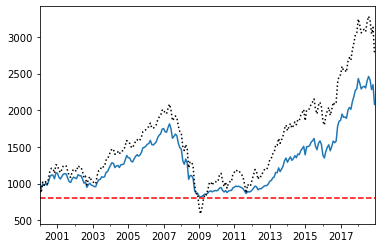

In [203]:
ind = "Fin"
ax = account_history[ind].plot()
risky_wealth[ind].plot(style="k:")
ax.axhline(y=floor_value, color='r', linestyle='--')

<AxesSubplot:>

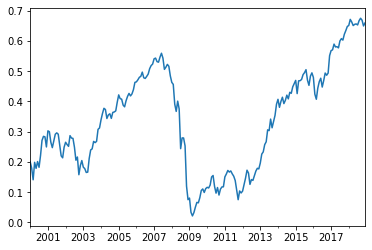

In [204]:
 cushion_history["Fin"].plot()

<AxesSubplot:>

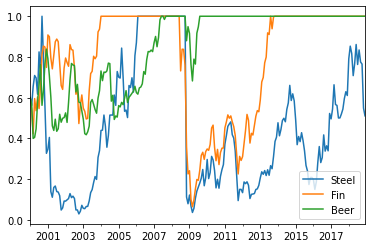

In [205]:
risky_w_history.plot()

Mettons tout cela dans une nouvelle fonction que nous pouvons ajouter à notre `asset_management_kit.py`:

```python
def run_cppi(risky_r, safe_r=None, m=3, start=1000, floor=0.8, riskfree_rate=0.03):
    """
    Exécution d'un backtest de la stratégie CPPI, étant donné un ensemble de rendements pour l'actif risqué
    Renvoie un dictionnaire contenant : l'historique de la valeur de l'actif,
    l'historique du budget de risque,'historique de la pondération risquée
    """
    # mise en place des paramètres CPPI
    dates = risky_r.index
    n_steps = len(dates)
    account_value = start
    floor_value = start*floor

    if isinstance(risky_r, pd.Series): 
        risky_r = pd.DataFrame(risky_r, columns=["R"])

    if safe_r is None:
        safe_r = pd.DataFrame().reindex_like(risky_r)
        safe_r.values[:] = riskfree_rate/12 # moyen rapide de définir toutes les valeurs sur un nombre
    # mise en place des DataFrames pour enregistrer les valeurs intermédiaires
    account_history = pd.DataFrame().reindex_like(risky_r)
    risky_w_history = pd.DataFrame().reindex_like(risky_r)
    cushion_history = pd.DataFrame().reindex_like(risky_r)
    
    for step in range(n_steps):
        cushion = (account_value - floor_value)/account_value
        risky_w = m*cushion
        risky_w = np.minimum(risky_w, 1)
        risky_w = np.maximum(risky_w, 0)
        safe_w = 1-risky_w
        risky_alloc = account_value*risky_w
        safe_alloc = account_value*safe_w
        # recalcul de la nouvelle valeur du compte à la fin de cette étape
        account_value = risky_alloc*(1+risky_r.iloc[step]) + safe_alloc*(1+safe_r.iloc[step])
        # sauvegarde des historiques pour analyse et tracé
        cushion_history.iloc[step] = cushion
        risky_w_history.iloc[step] = risky_w
        account_history.iloc[step] = account_value
    risky_wealth = start*(1+risky_r).cumprod()
    backtest_result = {
        "Wealth": account_history,
        "Risky Wealth": risky_wealth, 
        "Risk Budget": cushion_history,
        "Risky Allocation": risky_w_history,
        "m": m,
        "start": start,
        "floor": floor,
        "risky_r":risky_r,
        "safe_r": safe_r
    }
    return backtest_result

```


Ecrivons également une fonction pratique pour fournir des statistiques récapitulatives sur un ensemble de retours :
```python

def summary_stats(r, riskfree_rate=0.03):
    """
    Renvoie un DataFrame qui contient des statistiques récapitulatives agrégées pour
    les retours dans les colonnes de r
    """
    ann_r = r.aggregate(annualize_rets, periods_per_year=12)
    ann_vol = r.aggregate(annualize_vol, periods_per_year=12)
    ann_sr = r.aggregate(sharpe_ratio, riskfree_rate=riskfree_rate, periods_per_year=12)
    dd = r.aggregate(lambda r: drawdown(r).Drawdown.min())
    skew = r.aggregate(skewness)
    kurt = r.aggregate(kurtosis)
    cf_var5 = r.aggregate(var_gaussian, modified=True)
    hist_cvar5 = r.aggregate(cvar_historic)
    return pd.DataFrame({
        "Annualized Return": ann_r,
        "Annualized Vol": ann_vol,
        "Skewness": skew,
        "Kurtosis": kurt,
        "Cornish-Fisher VaR (5%)": cf_var5,
        "Historic CVaR (5%)": hist_cvar5,
        "Sharpe Ratio": ann_sr,
        "Max Drawdown": dd
    })

```

<AxesSubplot:>

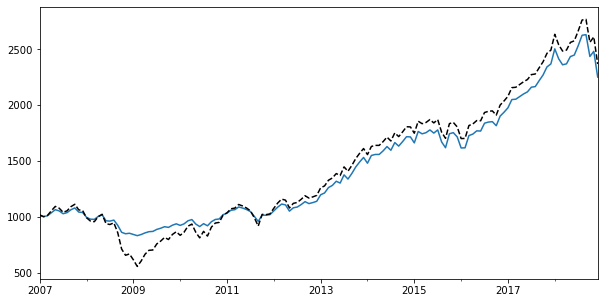

In [211]:
tmi_return = amk.get_total_market_index_returns()
btr = amk.run_cppi(tmi_return["2007":])
ax = btr["Wealth"].plot(legend=False, figsize=(10, 5))
btr["Risky Wealth"].plot(ax = ax, style="k--", legend=False)

<AxesSubplot:>

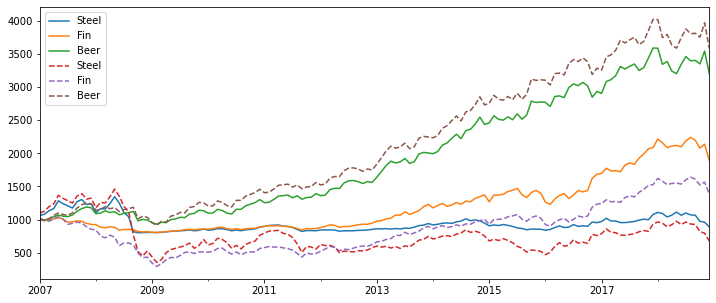

In [223]:
btr = amk.run_cppi(ind_return["2007":][["Steel", "Fin", "Beer"]])
ax = btr["Wealth"].plot(figsize=(12,5))
btr["Risky Wealth"].plot(ax=ax, style="--")

In [225]:
amk.summary_stats(btr["Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,-0.014490,0.126906,-1.554266,11.668243,0.068652,0.098467,-0.341351,-0.404132
Fin,0.054690,0.109579,-0.254976,5.589082,0.047503,0.068951,0.219159,-0.216868
Beer,0.101518,0.114363,-0.743585,4.527865,0.051074,0.069081,0.608531,-0.217280


In [227]:
amk.summary_stats(btr["Risky Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,-0.039660,0.306407,-0.459951,4.782828,0.152288,0.203837,-0.221642,-0.758017
Fin,0.027364,0.212204,-0.695200,4.621401,0.105744,0.149862,-0.012370,-0.718465
Beer,0.111554,0.127971,-0.670797,4.650878,0.056497,0.077388,0.620132,-0.271368


<AxesSubplot:>

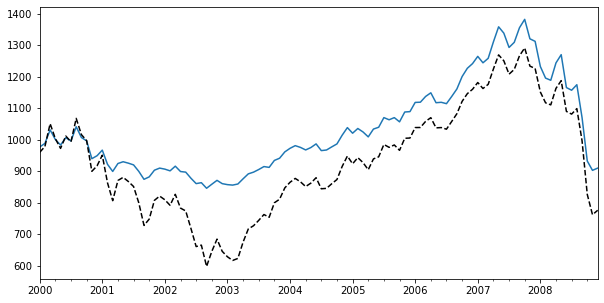

In [229]:
btr = amk.run_cppi(tmi_return["2000":"2008"])
ax = btr["Wealth"].plot(legend=False, figsize=(10, 5))
btr["Risky Wealth"].plot(ax = ax, style="k--", legend=False)

Les stratégies d'assurance aident généralement sur les aspets drawdown, mais elles peuvent également être adaptées pour limiter explicitement le drawdown.

## Limitation explicite des drawdown

Nous modifions le code pour ajuster le plancher si nécessaire, en fonction d'un nouveau paramètre supplémentaire "drawdown".

```python
        if drawdown is not None:
            peak = np.maximum(peak, account_value)
            floor_value = peak*(1-drawdown)
```

Nous pouvons maintenant appeler `run_cppi` avec un paramètre `drawdown`. Par exemple, pour exécuter CPPI et limiter le drawdown à 25 %

<AxesSubplot:>

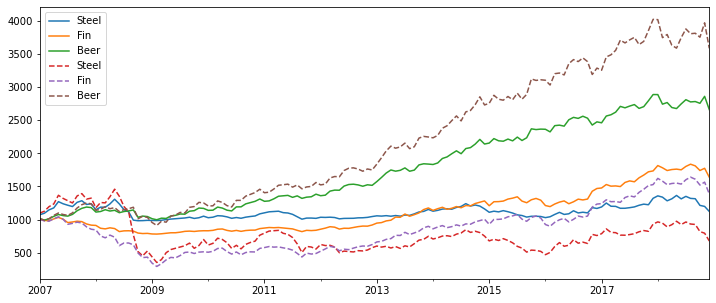

In [231]:
btr = amk.run_cppi(ind_return["2007":][["Steel", "Fin", "Beer"]], drawdown=0.25)
ax = btr["Wealth"].plot(figsize=(12,5))
btr["Risky Wealth"].plot(ax=ax, style="--")

In [233]:
amk.summary_stats(btr["Wealth"].pct_change().dropna())[["Annualized Return", "Annualized Vol", "Sharpe Ratio", "Max Drawdown"]]

,Annualized Return,Annualized Vol,Sharpe Ratio,Max Drawdown
Steel,0.003784,0.097073,-0.262958,-0.248059
Fin,0.041975,0.085028,0.136964,-0.243626
Beer,0.084375,0.086263,0.613413,-0.161186


In [235]:
amk.summary_stats(btr["Risky Wealth"].pct_change().dropna())[["Annualized Return", "Annualized Vol", "Sharpe Ratio", "Max Drawdown"]]

,Annualized Return,Annualized Vol,Sharpe Ratio,Max Drawdown
Steel,-0.039660,0.306407,-0.221642,-0.758017
Fin,0.027364,0.212204,-0.012370,-0.718465
Beer,0.111554,0.127971,0.620132,-0.271368


<AxesSubplot:>

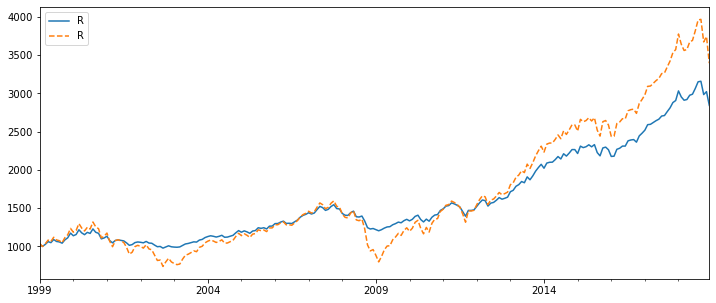

In [237]:
btr = amk.run_cppi(tmi_return["1999":], drawdown=0.25)
ax = btr["Wealth"].plot(figsize=(12,5))
btr["Risky Wealth"].plot(ax=ax, style="--")

In [239]:
amk.summary_stats(btr["Wealth"].pct_change().dropna())[["Annualized Return", "Annualized Vol", "Sharpe Ratio", "Max Drawdown"]]

,Annualized Return,Annualized Vol,Sharpe Ratio,Max Drawdown
R,0.052391,0.078951,0.275935,-0.220824


In [241]:
amk.summary_stats(btr["Risky Wealth"].pct_change().dropna())[["Annualized Return", "Annualized Vol", "Sharpe Ratio", "Max Drawdown"]]

,Annualized Return,Annualized Vol,Sharpe Ratio,Max Drawdown
R,0.06137,0.148571,0.205314,-0.499943
